In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [3]:
# data prepratation
df = pd.read_csv('./data/co2-mm-mlo.csv', parse_dates=['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df['time_idx'] = np.arange(len(df))
df['month'] = df['Date'].dt.month
y = df['Interpolated'].values

In [18]:
# Assume monthly data; last 10 years = 10*12 = 120 months
n_forecast = 10 * 12  
train_df = df.iloc[:-n_forecast]
test_df = df.iloc[-n_forecast:]
y_train = train_df['Interpolated'].values
y_test = test_df['Interpolated'].values

In [ ]:
with pm.Model() as bsts_model:
    sigma_level = pm.HalfNormal("sigma_level", sigma=10.0)
    sigma_obs   = pm.HalfNormal("sigma_obs", sigma=10.0)
    
    mu0 = pm.Normal("mu0", mu=y[0], sigma=20.0)
    mu_rw = pm.GaussianRandomWalk("mu_rw", sigma=sigma_level, shape=len(df)-1)
    mu = pm.Deterministic("mu", pm.math.concatenate([[mu0], mu0 + pm.math.cumsum(mu_rw)]))
    
    seasonal_raw = pm.Normal("seasonal_raw", mu=0.0, sigma=10.0, shape=12)
    seasonal_effect = pm.Deterministic("seasonal_effect", seasonal_raw - pm.math.mean(seasonal_raw))
    
    month_effect = seasonal_effect[df['month'].values - 1]  # adjust for 0-indexing

    mu_obs = mu + month_effect

    y_obs = pm.Normal("y_obs", mu=mu_obs, sigma=sigma_obs, observed=y_train[:-1])
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_level, sigma_obs, mu0, mu_rw, seasonal_raw]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 246 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
print(az.summary(trace, var_names=["sigma_level", "sigma_obs", "mu0"]))

                mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_level    0.032  0.004    0.025    0.039      0.000    0.000     282.0   
sigma_obs      0.240  0.007    0.227    0.254      0.000    0.000    1872.0   
mu0          314.778  0.154  314.484  315.065      0.002    0.002    6596.0   

             ess_tail  r_hat  
sigma_level     615.0   1.01  
sigma_obs      3834.0   1.00  
mu0            6381.0   1.00  


Sampling: [y_obs]


Output()

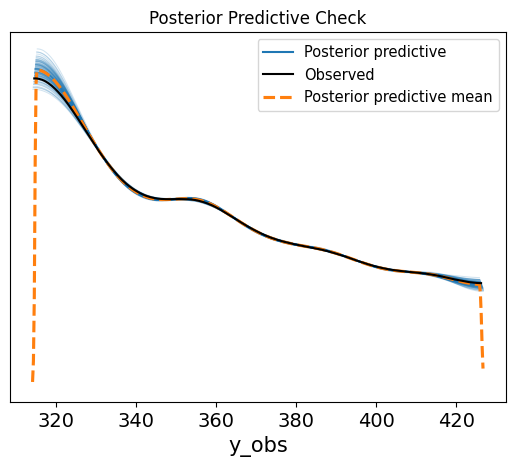

In [14]:
with bsts_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)

az.plot_ppc(ppc, data_pairs={"y_obs": "y_obs"}, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.show()

Text(0.5, 1.0, 'u-value')

/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


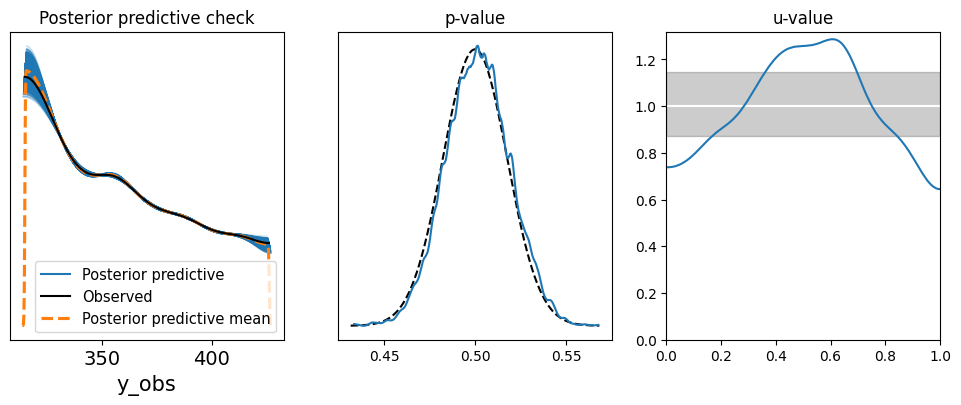

In [15]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
az.plot_ppc(ppc, ax=axs[0])
az.plot_bpv(ppc,  kind="p_value", hdi_prob=0.95, ax=axs[1])
az.plot_bpv(ppc,  kind="u_value", hdi_prob=0.95, ax=axs[2])

axs[0].set_title("Posterior predictive check")
axs[1].set_title("p-value")
axs[2].set_title("u-value")

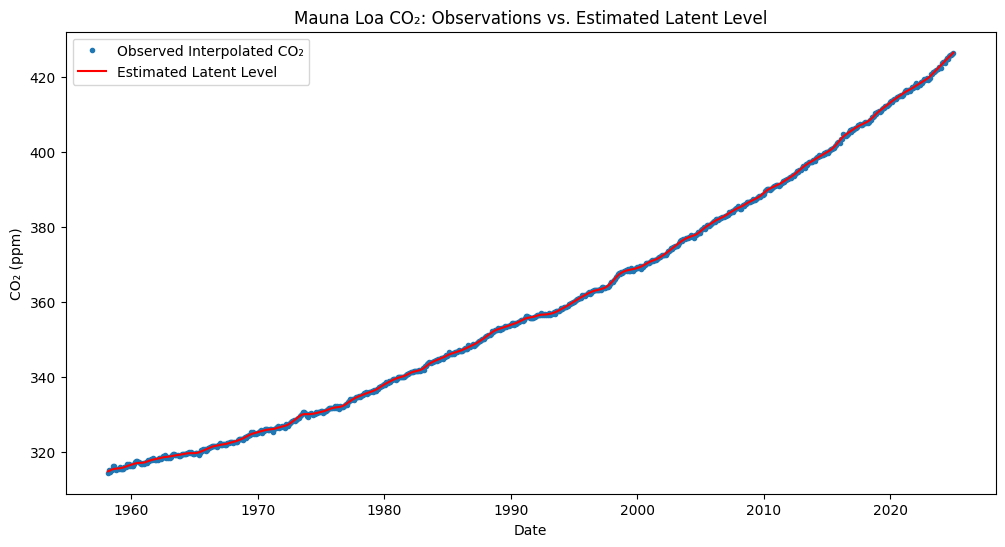

In [8]:
mu_post_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], y, 'o', markersize=3, label="Observed Interpolated CO₂")
plt.plot(df['Date'], mu_post_mean, label="Estimated Latent Level", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Mauna Loa CO₂: Observations vs. Estimated Latent Level")
plt.legend()
plt.show()

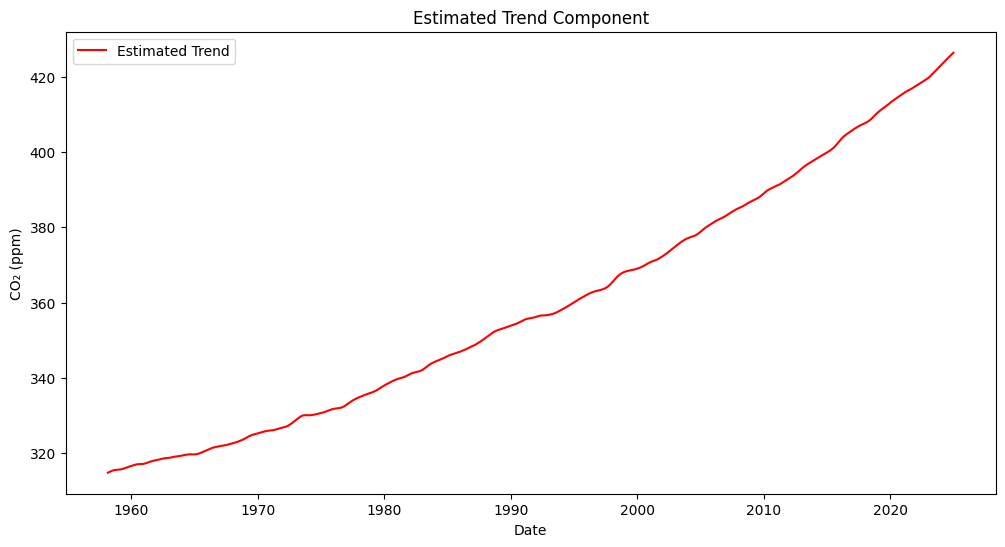

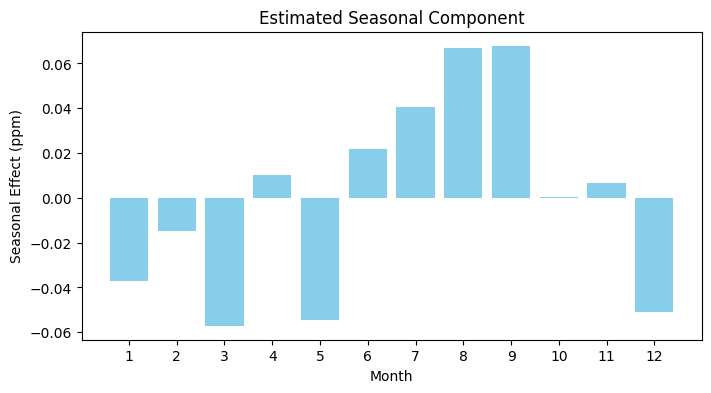

In [9]:
# Extract the posterior mean for the latent trend (mu) and seasonal_effect.
# Here we average over chains and draws.
mu_post_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values
seasonal_effect_mean = trace.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values

# Plot the latent trend (time-varying component)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], mu_post_mean, label="Estimated Trend", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Estimated Trend Component")
plt.legend()
plt.show()

# Plot the seasonal component (one value per month)
plt.figure(figsize=(8, 4))
months = np.arange(1, 13)
plt.bar(months, seasonal_effect_mean, color="skyblue")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component")
plt.xticks(months)
plt.show()

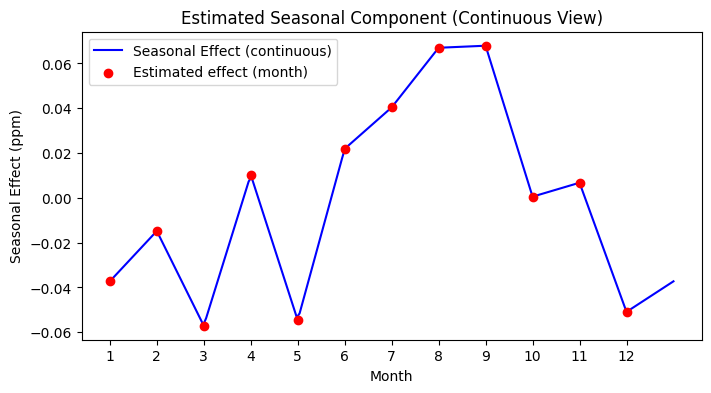

In [10]:
# Extract the posterior mean for the seasonal effect (12 months)
seasonal_effect_mean = trace.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values

# Create an array of month numbers (1 to 12)
months = np.arange(1, 13)

# For a continuous plot, append the first value at month 13 to complete the cycle.
months_extended = np.append(months, 13)
seasonal_extended = np.append(seasonal_effect_mean, seasonal_effect_mean[0])

# Create a finer grid for a smooth plot
x_fine = np.linspace(1, 13, 200)
seasonal_continuous = np.interp(x_fine, months_extended, seasonal_extended)

plt.figure(figsize=(8, 4))
plt.plot(x_fine, seasonal_continuous, label="Seasonal Effect (continuous)", color="blue")
plt.scatter(months, seasonal_effect_mean, color="red", zorder=5, label="Estimated effect (month)")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component (Continuous View)")
plt.xticks(months)
plt.legend()
plt.show()

In [ ]:
# Assume monthly data; last 10 years = 10*12 = 120 months
n_forecast = 10 * 12  
train_df = df.iloc[:-n_forecast]
test_df = df.iloc[-n_forecast:]
y_train = train_df['Interpolated'].values
y_test = test_df['Interpolated'].values

In [17]:
with pm.Model() as bsts_local_linear:
    sigma_level = pm.HalfNormal("sigma_level", sigma=10.0)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=1.0)
    sigma_obs   = pm.HalfNormal("sigma_obs", sigma=10.0)
    
    level0 = pm.Normal("level0", mu=y[0], sigma=20.0)
    slope0 = pm.Normal("slope0", mu=0.0, sigma=1.0)
    
    rw_slope = pm.GaussianRandomWalk("rw_slope", sigma=sigma_slope, shape=len(df)-1)
    slope = pm.Deterministic("slope", pm.math.concatenate([[slope0], rw_slope]))
    
    # Compute latent level based on cumulative sum of slope (excluding the last element for consistent shape)
    level = pm.Deterministic("level", level0 + pm.math.cumsum(slope[:-1]))
    
    seasonal_raw = pm.Normal("seasonal_raw", mu=0.0, sigma=10.0, shape=12)
    seasonal_effect = pm.Deterministic("seasonal_effect", seasonal_raw - pm.math.mean(seasonal_raw))
    # Use only the first len(df)-1 month values so that shapes match
    month_effect = seasonal_effect[df['month'].values[:-1] - 1]
    
    mu_obs = level + month_effect
    
    y_obs = pm.Normal("y_obs", mu=mu_obs, sigma=sigma_obs, observed=y[:-1])
    
    trace_ll = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)


/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 